In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [33]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
# elif torch.backends.mps.is_available():
#     device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

device

'cpu'

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),    
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Skorch can handle PyTorch Datasets directly
X_train, y_train = train_dataset.data.float().unsqueeze(1), train_dataset.targets
X_test, y_test = test_dataset.data.float().unsqueeze(1), test_dataset.targets

In [44]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

In [43]:
# 1. Define your CNN module

class SimpleCNN(nn.Module):
    def __init__(self, channels=32, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.fc1   = nn.Linear((channels * 2) * 7 * 7, 128)
        self.fc2   = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x

In [19]:
# 2. Prepare dataset (FashionMNIST)

# transform = transforms.Compose([
#     transforms.ToTensor()
#     , transforms.Normalize((0.5,), (0.5,))
# ])

# train_data = datasets.FashionMNIST(
#     root="./data"
#     , train=True
#     , download=True
#     , transform=transform
# )

# X = train_data.data.unsqueeze(1).float() / 255.0  # shape: (N, 1, 28, 28)
# y = train_data.targets

# X.shape, y.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [35]:
# train_data = datasets.FashionMNIST(
#     root="./data",
#     train=True,
#     download=True,
#     transform=transform
# )
# X = train_data.data.numpy()  # or just pass train_data directly
# y = train_data.targets.numpy()

# X.shape, y.shape

((60000, 28, 28), (60000,))

In [47]:
net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=10
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

net.fit(X_train, y_train)
print("Train accuracy:", net.score(X, y))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6025       0.8494        0.4165  14.9288
      2        0.3653       0.8773        0.3444  15.8009
      3        0.3165       0.8967        0.2916  16.2570
      4        0.2775       0.8996        0.2868  15.7578
      5        0.2531       0.9024        0.2741  16.1300
      6        0.2361       0.9077        0.2512  16.3023
      7        0.2173       0.9093        0.2517  16.1267
      8        0.1993       0.9157        0.2292  15.7634
      9        0.1860       0.9143        0.2354  16.2944
     10        0.1741       0.9222        0.2199  15.8141
Train accuracy: 0.9430833333333334


In [52]:
net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=10
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

net.fit(X_train, y_train)
print("Train accuracy:", net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.9513       0.8819        0.3327  15.1738
      2        0.3071       0.8898        0.2925  16.3234
      3        0.2631       0.9037        0.2708  16.0947
      4        0.2287       0.9064        0.2603  15.1317
      5        0.2116       0.9122        0.2541  15.0414
      6        0.1900       0.9096        0.2638  15.5097
      7        0.1734       0.9138        0.2519  15.6656
      8        0.1605       0.9093        0.2676  15.2011
      9        0.1513       0.9073        0.2830  16.9694
     10        0.1361       0.9124        0.2824  15.2532
Train accuracy: 0.9505


In [53]:
# 3. Wrap model with skorch

net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=10
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

In [40]:
# net.fit(X, y)
# print(net.score(X, y))  # should be far above 10%

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1           nan       0.1000           nan  16.0133
      2           nan       0.1000           nan  16.0808
      3           nan       0.1000           nan  15.7180
      4           nan       0.1000           nan  15.4871
      5           nan       0.1000           nan  15.7791
      6           nan       0.1000           nan  16.5335
      7           nan       0.1000           nan  17.8743
      8           nan       0.1000           nan  15.5864
      9           nan       0.1000           nan  15.1555
     10           nan       0.1000           nan  16.5533
0.1


In [54]:
# 4. Define parameter grid
#    Note: use 'module__' prefix for module args

param_grid = {
    "module__channels": [32, 64]
    , "module__dropout": [0.0, 0.25, 0.5] 
    , "lr": [1e-4, 3e-4, 1e-3]
    , "optimizer": [torch.optim.Adam]
    , "batch_size": [256]
    , "max_epochs": [3]
}

In [55]:
%%time

# 5B. Faster Randomized Search (params setup)

param_dist = {
    "module__channels": [32, 64]
    , "module__dropout": [0.0, 0.25, 0.5]
    , "lr": [1e-4, 3e-4, 1e-3]
    , "optimizer": [torch.optim.Adam]
    , "batch_size": [256]
}

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 9.78 µs


In [58]:
%%time

# 5C. Faster Randomized Search (sample combos, actual run;)

rs = RandomizedSearchCV(
    estimator=net
    , param_distributions=param_dist
    , n_iter=10          # try only 10 random combos
    , cv=2
    , scoring="accuracy"
    , verbose=1
    , random_state=27
    , n_jobs=-1
)

# Fit the randomized search
rs.fit(X_train, y_train)

print("Best CV accuracy:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.0883       0.8482        0.4357  29.3791
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5037       0.8477        0.4452  30.5034
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.5668       0.8365        0.4487  31.0023
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5056       0.8520        0.4209  32.0802
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.2010       0.8167        0.5092  33.0554
  epoch    train_loss    valid_acc    valid_loss      dur
-------  --

      8        0.2677       0.8895        0.3275  55.2622
      3        0.3479       0.8908        0.3073  138.1968
      3        0.3160       0.8825        0.3211  133.4053
      6        0.2273       0.8965        0.2986  54.5514
      3        0.2891       0.8850        0.3143  133.3826
      9        0.2089       0.9012        0.2765  55.4917
      9        0.2300       0.9012        0.2755  55.2493
      9        0.3238       0.8843        0.3018  55.0932
      3        0.3364       0.8772        0.3504  133.9014
      9        0.2907       0.8935        0.2911  55.9482
      9        0.2403       0.8933        0.3196  54.4731
      7        0.2152       0.8945        0.3064  54.1228
      3        0.3336       0.8823        0.3439  133.9700
      9        0.2492       0.8917        0.3210  55.3045
      7        0.2050       0.8967        0.2911  54.6255
     10        0.1977       0.9065        0.2767  58.7672
     10        0.2160       0.9023        0.2746  59.2255
     10  

      8        0.1681       0.8928        0.3097  123.5742
      9        0.1550       0.8912        0.3432  50.1420
      8        0.2364       0.9098        0.2582  126.7392
     10        0.2266       0.8970        0.2915  51.5017
      8        0.1913       0.8990        0.2893  123.1415
      8        0.2038       0.9052        0.2709  123.7801
     10        0.2237       0.8980        0.2915  50.7874
     10        0.1425       0.8852        0.3450  50.0314
     10        0.1431       0.8948        0.3321  48.6433
      8        0.2721       0.8995        0.2850  119.6870
      9        0.1773       0.8990        0.3155  114.6988
      9        0.2510       0.8857        0.2989  116.1629
      8        0.2601       0.9023        0.2795  115.7168
      9        0.1479       0.8885        0.3560  113.1044
      9        0.2165       0.9125        0.2562  114.4786
      9        0.1734       0.9010        0.2869  109.4813
      9        0.1810       0.9012        0.2884  109.1556
  

In [59]:
# Send results to a dataframe for clean review;

results = pd.DataFrame(rs.cv_results_)
results[[
    "mean_test_score"
    , "std_test_score"
    , "params"
]].sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,params
0,0.902533,0.003000,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
3,0.901567,0.000233,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
8,0.898767,0.000100,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
7,0.898600,0.001733,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
5,0.897583,0.004383,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
6,0.893900,0.001567,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
4,0.891833,0.001500,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
1,0.891467,0.001467,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
9,0.889883,0.003083,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."
2,0.885150,0.002183,"{'optimizer': <class 'torch.optim.adam.Adam'>,..."


In [60]:
results['params'].iloc[0]

{'optimizer': torch.optim.adam.Adam,
 'module__dropout': 0.25,
 'module__channels': 32,
 'lr': 0.0003,
 'batch_size': 256}

In [65]:
rs.best_estimator_

,module,<class '__main__.SimpleCNN'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,<skorch.datas...t 0x19c354610>
,classes,None
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.0003
,max_epochs,10
,batch_size,256
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


In [66]:
best_rand_cv = rs.best_estimator_
best_rand_cv

,module,<class '__main__.SimpleCNN'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,<skorch.datas...t 0x19c354610>
,classes,None
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.0003
,max_epochs,10
,batch_size,256
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


In [67]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [69]:
# Predict with best estimator
y_pred = rs.best_estimator_.predict(
    X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

acc
print(report)
cm

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.84      0.86      1000
           3       0.89      0.94      0.92      1000
           4       0.83      0.89      0.86      1000
           5       0.98      0.99      0.98      1000
           6       0.80      0.65      0.71      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.99      0.98      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



array([[894,   2,  10,  19,   2,   1,  67,   0,   5,   0],
       [  2, 981,   0,  14,   1,   0,   1,   0,   1,   0],
       [ 23,   0, 842,   9,  83,   0,  42,   0,   1,   0],
       [ 12,   5,   7, 939,  19,   0,  16,   0,   2,   0],
       [  1,   1,  40,  33, 889,   0,  35,   0,   1,   0],
       [  0,   0,   0,   0,   0, 988,   0,  11,   0,   1],
       [169,   1,  65,  33,  80,   0, 645,   0,   7,   0],
       [  0,   0,   0,   0,   0,  12,   0, 977,   0,  11],
       [  2,   1,   0,   5,   1,   2,   1,   2, 986,   0],
       [  1,   0,   0,   0,   0,   6,   0,  44,   0, 949]])

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

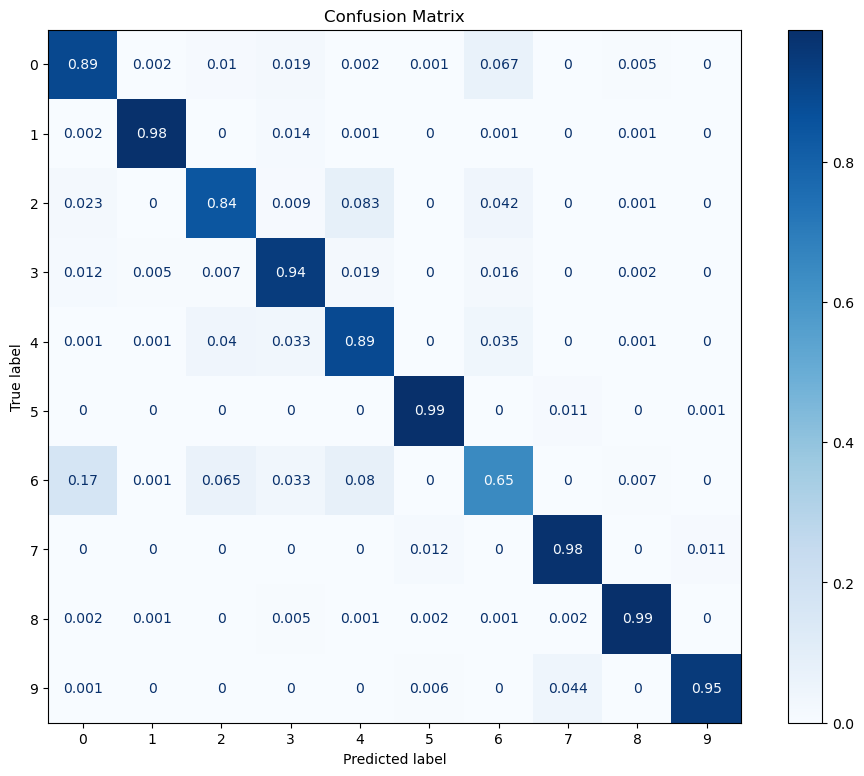

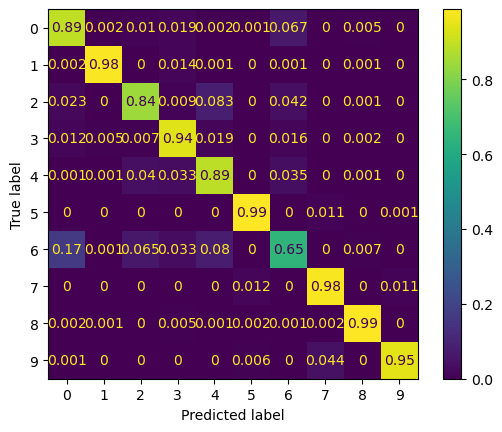

In [81]:
# Create a Matplotlib figure and axes with the desired figsize
fig, ax = plt.subplots(figsize=(12, 9)) # Adjust width and height as needed

# Create a ConfusionMatrixDisplay object (note creating an obj then running the object still outputs a mini cm, which looks strange, so just adding '.plot' to the end of the unnamed obj;)

ConfusionMatrixDisplay.from_estimator(
    rs, X_test, y_test
    , normalize='true'
).plot(ax=ax, cmap='Blues')

# Add a title (optional)
ax.set_title('Confusion Matrix')

# Display the plot
plt.show();

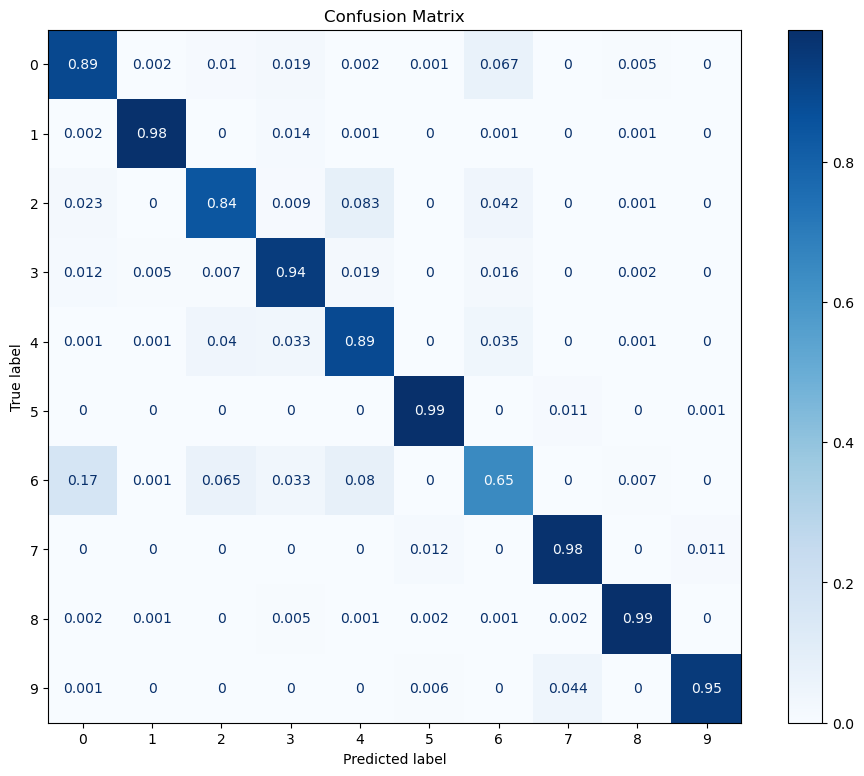

In [79]:
# Create a Matplotlib figure and axes with the desired figsize
fig, ax = plt.subplots(figsize=(12, 9)) # Adjust width and height as needed

# Plot the confusion matrix on the created axes
cmp.plot(ax=ax, cmap='Blues')

# Add a title (optional)
ax.set_title('Confusion Matrix')

# Display the plot
plt.show();

In [61]:
best_net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=20
    , lr=0.0003
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

best_net.fit(X_train, y_train)
print("Train accuracy:", best_net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.8366       0.8685        0.3710  15.5156
      2        0.3276       0.8840        0.3169  15.5024
      3        0.2766       0.8964        0.2846  16.8444
      4        0.2432       0.9051        0.2634  16.1104
      5        0.2250       0.8996        0.2804  16.0984
      6        0.2091       0.9104        0.2495  16.1239
      7        0.1855       0.9092        0.2460  16.1975
      8        0.1718       0.9107        0.2536  15.7750
      9        0.1641       0.9103        0.2449  15.8042
     10        0.1480       0.9035        0.2779  15.8287
     11        0.1358       0.9100        0.2621  15.6743
     12        0.1285       0.9146        0.2524  15.8504
     13        0.1145       0.9173        0.2499  15.6497
     14        0.1037       0.9168        0.2536  15.6584
     15        0.0999       0.9130        0.2649  15.7950
     16       

In [62]:
best_net.get_params

<bound method NeuralNet.get_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  ),
)>

In [63]:
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay)

In [ ]:
"""
# Predict with best estimator
y_pred = grid_search.best_estimator_.predict(
    X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

"""

In [64]:
final_model = NeuralNetClassifier(
    channels=best_params["channels"]
    , dropout=best_params["dropout"]
).to(device)

NameError: name 'best_params' is not defined

In [ ]:
# 5A. Exhaustive Grid Search (slow but complete)
# ---------------------------------------------------------
gs = GridSearchCV(
    estimator=net
    , param_grid=param_grid
    , cv=3               # 3-fold cross validation
    , scoring="accuracy" # use accuracy for FashionMNIST
    , verbose=2
    , n_jobs=-1          # parallelize if possible
)

# Fit the grid search
gs.fit(X, y)

print("Best CV accuracy:", gs.best_score_)
print("Best params:", gs.best_params_)